In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from fractions import Fraction

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Data source: https://www.kaggle.com/datasets/lantanacamara/hong-kong-horse-racing/data 

Feature definition: https://www.kaggle.com/datasets/lantanacamara/hong-kong-horse-racing/discussion/40574
- finishing_position: final position of the race (e.g. 3)
- horse_number: horse number (e.g. 10)
- horse_name: horse name (e.g. GOLDWEAVER)
- horse_id: unique horse id (e.g. P072)
- jockey: jockey name (e.g. Y T Cheng)
- trainer: trainer name (e.g. Y S Tsui)
- actual_weight: The total weight, in pounds, a runner carries during a race including jockey, saddle and extra metal weights. (e.g. 121)
- declared_horse_weight: horse weight in pounds (e.g. 1065)
- draw: The draw refers to a horse’s position in the starting gate. Draw number is randomly assigned by computer a couple of days before the race (e.g. 3)
- length_behind_winner: measurement in horse length between the winner and the running horse. A horse length is approximately 8 feet from nose to tail. (e.g. 2)
- running_position_1: Places during a race where the running positions are indicated in a track chart. (e.g. 2)
- running_position_2: Places during a race where the running positions are indicated in a track chart. (e.g. 1)
- running_position_3: Places during a race where the running positions are indicated in a track chart. (e.g. 1)
- running_position_4: Places during a race where the running positions are indicated in a track chart. (e.g. 3)
- finish_time: race finish time (e.g. 1.22.66)
- win_odds: winning odds and returns. For example win_odds = "3" means "1/3" or "33.3%" chance of winning and return is "3 x initial stake" (e.g. 5.7)
- running_position_5: Places during a race where the running positions are indicated in a track chart. (e.g. NA)
- running_position_6: Places during a race where the running positions are indicated in a track chart. (e.g. NA)
- race_id: race number (e.g. 2014-001)

Symbol Reference: https://racing.hkjc.com/racing/english/racing-info/special_race_index.asp
- DISQ: Disqualified - The horse was disqualified from the race due to a rule violation.
- DNF: Did Not Finish - The horse did not complete the race for some reason.
- FE: Horse fell during the race - Indicates that the horse fell during the race.
- ML: Many Lengths - Often used to describe the winning margin of a horse, indicating that it won by a significant number of lengths.
- PU: Pulled Up - The horse was withdrawn from the race by its jockey or stopped running before completing the race due to an issue.
- TNP: Took No Part - The horse was present at the start of the race but did not participate.
- TO: Tailed Off - The horse lagged far behind the rest of the field during the race.
- UR: Unseated Rider - The jockey fell off the horse during the race.
- VOID: Void Race - The race was declared void, often due to unforeseen circumstances or irregularities.
- WR: Withdrawn-by Starter - The horse was withdrawn from the race by the starter before the race began.
- WV: Withdrawn-on Veterinary Grounds - The horse was withdrawn from the race based on veterinary advice or grounds.
- WV-A: Withdrawn-on Veterinary Grounds after weighing out - The horse was withdrawn from the race based on veterinary advice after the weighing out process.
- WX: Withdrawn-by order of Stewards - The horse was withdrawn from the race by order of the stewards.
- WX-A: Withdrawn-by order of Stewards after weighing out - The horse was withdrawn from the race by order of the stewards after the weighing out process.
- WXNR: Withdrawn-non runner - The horse was withdrawn from the race as a non-runner, often due to injury or other reasons.

Reference for data exploration: https://www.kaggle.com/code/alberthkcheng/hong-kong-horse-racing-explained-with-data/notebook (Note that this reference uses outdated data)

# Data Cleaning and Exploration 

In [3]:
# import data
race_result_horse = pd.read_csv("./data/race-result-horse.csv")

In [4]:
race_result_horse.head()

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,running_position_2,running_position_3,running_position_4,finish_time,win_odds,running_position_5,running_position_6,race_id
0,1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133,1032,1,-,1.0,2.0,2.0,1.0,1.22.33,3.8,NaN,NaN,2014-001
1,2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133,1075,13,2,8.0,9.0,9.0,2.0,1.22.65,8,NaN,NaN,2014-001
2,3,10.0,GOLDWEAVER,P072,Y T Cheng,Y S Tsui,121,1065,3,2,2.0,1.0,1.0,3.0,1.22.66,5.7,NaN,NaN,2014-001
3,4,3.0,SUPREME PROFIT,P230,J Moreira,C S Shum,132,1222,2,2,6.0,4.0,5.0,4.0,1.22.66,6.1,NaN,NaN,2014-001
4,5,7.0,THE ONLY KID,H173,Z Purton,K W Lui,125,1136,9,4-1/4,9.0,10.0,10.0,5.0,1.23.02,6.1,NaN,NaN,2014-001


## Proportional to Win Odds Betting:

- Determine the total betting amount
- Convert the betting odds for each horse into implied probabilities
- Calculate the total implied probability for all horses and normalise it so they sum to 100%. Allocate the total betting amount among the horses based on their adjusted implied probabilities


In [5]:
race_result_horse.dropna(subset=['win_odds'], inplace=True)
race_result_horse['win_odds'] = pd.to_numeric(race_result_horse['win_odds'], errors='coerce')
race_result_horse['winning_chance'] = 1 / race_result_horse['win_odds']


Convert all 1 DH (Multiple winners) to 1 for finishing_position column

In [6]:
race_result_horse['finishing_position'] = race_result_horse['finishing_position'].astype(str)
race_result_horse['finishing_position'] = race_result_horse['finishing_position'].replace('1 DH', '1')


Count number of races with more than 1 winner

In [7]:
race_result_horse['finishing_position'] = race_result_horse['finishing_position'].astype(str)
race_result_horse['is_winner'] = race_result_horse['finishing_position'].isin(['1'])
winners_per_race = race_result_horse.groupby('race_id')['is_winner'].sum()
races_with_multiple_winners = winners_per_race[winners_per_race >= 2]
number_of_races_with_multiple_winners = races_with_multiple_winners.count()
print("Number of races with 2 or more winners:", number_of_races_with_multiple_winners)
number_of_unique_races = race_result_horse['race_id'].nunique()
percentage_races_with_multiple_winners = (number_of_races_with_multiple_winners / number_of_unique_races)*100
percentage_races_with_multiple_winners = "{:.2f}%".format(percentage_races_with_multiple_winners) 
print("Percentage of races with 2 or more winners:", percentage_races_with_multiple_winners)



Number of races with 2 or more winners: 6
Percentage of races with 2 or more winners: 0.25%


Calculate The Total Winning Chance per Race and Normalise win chance to 100% to determine bet weight per horse

In [8]:
race_result_horse['total_winning_chance'] = race_result_horse.groupby('race_id')['winning_chance'].transform('sum')
race_result_horse['bet_weight'] = race_result_horse['winning_chance'] / race_result_horse['total_winning_chance']

Calculate the PnL per Horse: If winner, profit equals (Win Odds * Bet Weight) - Bet Weight. If loser, loss equals Bet Weight

Calculate the PnL per Race: Sum of the PnL for each race

In [17]:
race_result_horse['finishing_position'] = race_result_horse['finishing_position'].astype(str)
race_result_horse['PnL'] = np.where(
    (race_result_horse['finishing_position'] == '1'),
    race_result_horse['bet_weight'] * race_result_horse['win_odds'] - race_result_horse['bet_weight'], 
    -race_result_horse['bet_weight'])

race_result_horse['Race PnL'] = race_result_horse.groupby('race_id')['PnL'].transform('sum')
race_result_horse.head(14)

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,...,win_odds,running_position_5,running_position_6,race_id,winning_chance,is_winner,total_winning_chance,bet_weight,PnL,Race PnL
0,1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133,1032,1,-,...,3.8,NaN,NaN,2014-001,0.263158,True,1.225693,0.214701,0.601164,-0.184135
1,2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133,1075,13,2,...,8.0,NaN,NaN,2014-001,0.125000,False,1.225693,0.101983,-0.101983,-0.184135
2,3,10.0,GOLDWEAVER,P072,Y T Cheng,Y S Tsui,121,1065,3,2,...,5.7,NaN,NaN,2014-001,0.175439,False,1.225693,0.143134,-0.143134,-0.184135
3,4,3.0,SUPREME PROFIT,P230,J Moreira,C S Shum,132,1222,2,2,...,6.1,NaN,NaN,2014-001,0.163934,False,1.225693,0.133748,-0.133748,-0.184135
4,5,7.0,THE ONLY KID,H173,Z Purton,K W Lui,125,1136,9,4-1/4,...,6.1,NaN,NaN,2014-001,0.163934,False,1.225693,0.133748,-0.133748,-0.184135
5,6,9.0,WINNING ADVANTAGE,N359,A Suborics,A T Millard,123,1100,11,5-1/2,...,24.0,NaN,NaN,2014-001,0.041667,False,1.225693,0.033994,-0.033994,-0.184135
6,7,13.0,CARE FREE ELEGANCE,P340,C Y Ho,K L Man,115,1053,12,5-1/2,...,99.0,NaN,NaN,2014-001,0.010101,False,1.225693,0.008241,-0.008241,-0.184135
7,8,4.0,COOL PAL,S035,H W Lai,L Ho,129,1203,8,5-3/4,...,21.0,NaN,NaN,2014-001,0.047619,False,1.225693,0.038851,-0.038851,-0.184135
8,9,6.0,TAI PO FORTUNE,P081,K Teetan,T P Yung,127,1073,6,6-1/4,...,10.0,NaN,NaN,2014-001,0.100000,False,1.225693,0.081586,-0.081586,-0.184135
9,10,11.0,SUPER HORSE,L308,T H So,C W Chang,119,1137,7,6-3/4,...,27.0,NaN,NaN,2014-001,0.037037,False,1.225693,0.030217,-0.030217,-0.184135


In [59]:
selected_columns = race_result_horse[['horse_name', 'win_odds', 'winning_chance','total_winning_chance']].head(14)
#selected_columns.rename(columns={'bet_weight': 'normalised_winning_chance'}, inplace=True)
#selected_columns['fair_win_odds'] = 1 / selected_columns['normalised_winning_chance']
#print(selected_columns)

from IPython.display import display

# Assuming your DataFrame is named selected_columns
display(selected_columns)





new_df = race_result_horse.groupby('race_id')['total_winning_chance'].first().reset_index()
print(new_df)
print(new_df['total_winning_chance'].mean())


,horse_name,win_odds,winning_chance,total_winning_chance
0,DOUBLE DRAGON,3.8,0.263158,1.225693
1,PLAIN BLUE BANNER,8.0,0.125000,1.225693
2,GOLDWEAVER,5.7,0.175439,1.225693
3,SUPREME PROFIT,6.1,0.163934,1.225693
4,THE ONLY KID,6.1,0.163934,1.225693
5,WINNING ADVANTAGE,24.0,0.041667,1.225693
6,CARE FREE ELEGANCE,99.0,0.010101,1.225693
7,COOL PAL,21.0,0.047619,1.225693
8,TAI PO FORTUNE,10.0,0.100000,1.225693
9,SUPER HORSE,27.0,0.037037,1.225693


       race_id  total_winning_chance
0     2014-001              1.225693
1     2014-002              1.230202
2     2014-003              1.238693
3     2014-004              1.238205
4     2014-005              1.233696
...        ...                   ...
2362  2016-803              1.233857
2363  2016-804              1.228792
2364  2016-805              1.241043
2365  2016-806              1.226122
2366  2016-807              1.230842

[2367 rows x 2 columns]
1.2332881858312392


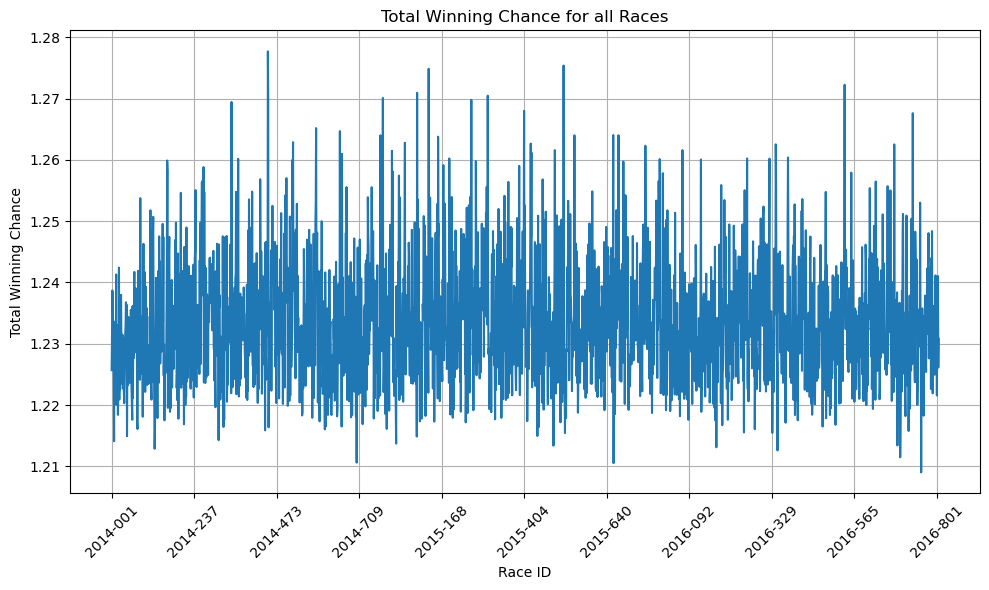

Number of unique race IDs: 2367


In [51]:
# Assuming plot_data is your DataFrame with the first 3000 races
plot_data = new_df.head(3000)

plt.figure(figsize=(10, 6))
plt.plot(plot_data['race_id'], plot_data['total_winning_chance'], marker='', linestyle='-')
plt.title('Total Winning Chance for all Races')
plt.xlabel('Race ID')
plt.ylabel('Total Winning Chance')

# Thin out the x-axis labels
tick_spacing = len(plot_data) // 10  # Adjust the divisor as needed for optimal label density
plt.xticks(plot_data['race_id'][::tick_spacing], rotation=45)

plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

number_of_unique_races = new_df['race_id'].nunique()

print(f"Number of unique race IDs: {number_of_unique_races}")


In [10]:
race_pnl_df = race_result_horse.groupby('race_id')['Race PnL'].first().reset_index()
mean_value = race_pnl_df['Race PnL'].mean()
max_value = race_pnl_df['Race PnL'].max()
median_value = race_pnl_df['Race PnL'].median()
min_value = race_pnl_df['Race PnL'].min()

print("Mean Race PnL:", mean_value)
print("Max Race PnL:", max_value)
print("Median Race PnL:", median_value)
print("Min Race PnL:", min_value)



Mean Race PnL: -0.18705257474429174
Max Race PnL: 0.6378033241820212
Median Race PnL: -0.1883868286735675
Min Race PnL: -0.21734340082134967


Add 1 to the PnL to calculate cumulative product for wealth curve

In [20]:
race_pnl_df['PnL_Multiplier'] = ((race_pnl_df['Race PnL']))*100
race_pnl_df['Wealth'] = race_pnl_df['PnL_Multiplier'].cumsum()

Plot the Wealth Curve (Using only first 10 races since due to large losses per race)

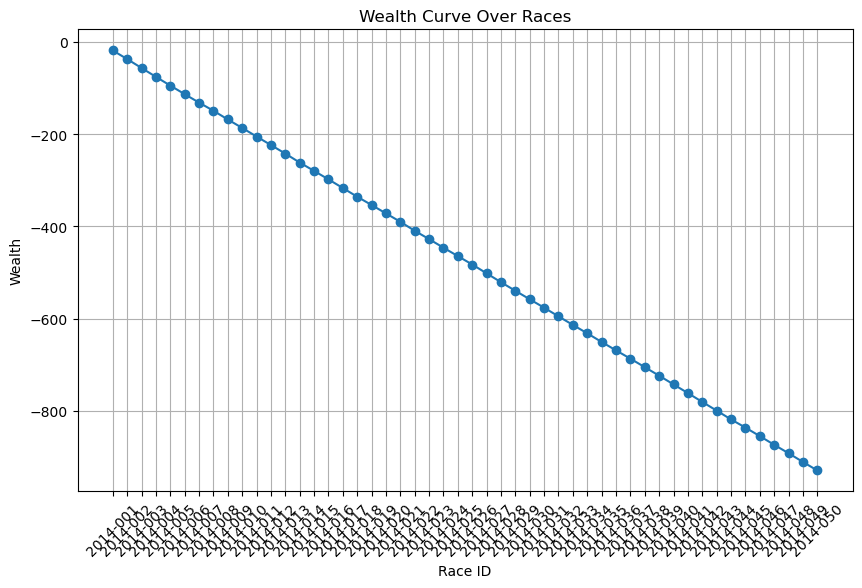

In [29]:
subset_df = race_pnl_df.head(50)

plt.figure(figsize=(10, 6))
plt.plot(subset_df['race_id'], subset_df['Wealth'], marker='o', linestyle='-')
plt.title('Wealth Curve Over Races')
plt.xlabel('Race ID')
plt.ylabel('Wealth')
plt.xticks(rotation=45)  # Rotate race IDs for better readability, if necessary
plt.grid(True)
plt.show()

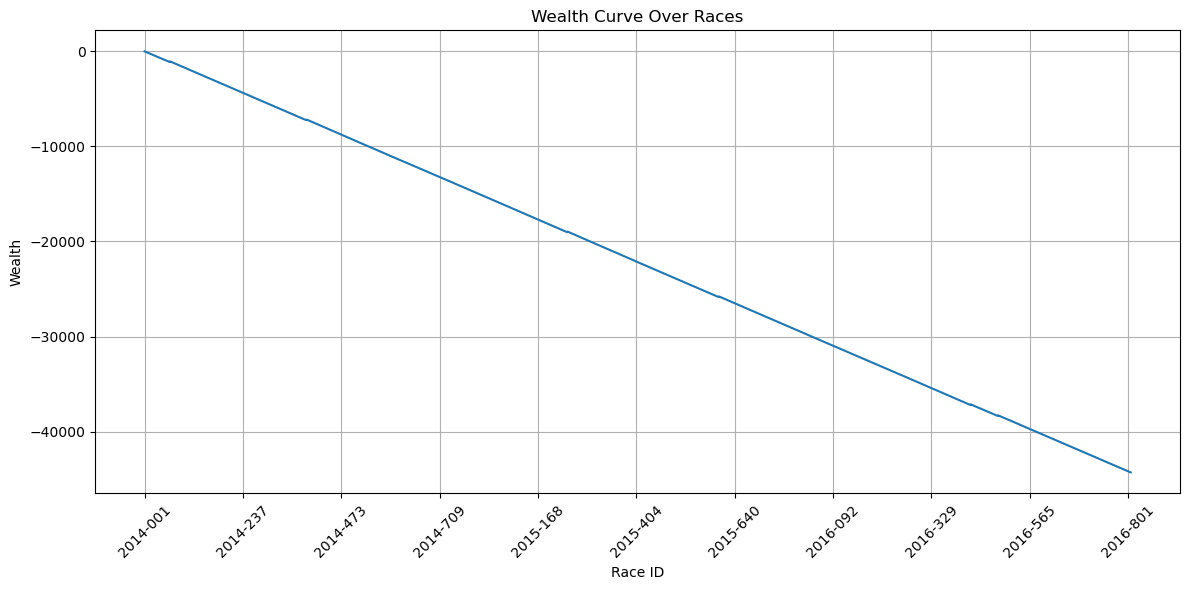

In [39]:
subset_df = race_pnl_df.head(3000)
# Assuming 'subset_df' is your DataFrame and it's sorted by 'race_id'
plt.figure(figsize=(12, 6))  # Slightly larger figure size for better clarity

# Plotting without markers for clarity with a large number of data points
plt.plot(subset_df['race_id'], subset_df['Wealth'], linestyle='-')

plt.title('Wealth Curve Over Races')
plt.xlabel('Race ID')
plt.ylabel('Wealth')

# Thinning out the x-axis labels to prevent overlap and improve readability
# Displaying every nth label where n is determined by the total number of races divided by a fixed number (e.g., 10 for 2000 data points)
n = len(subset_df['race_id']) // 10
plt.xticks(subset_df['race_id'][::n], rotation=45)  # Adjust rotation if necessary

plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


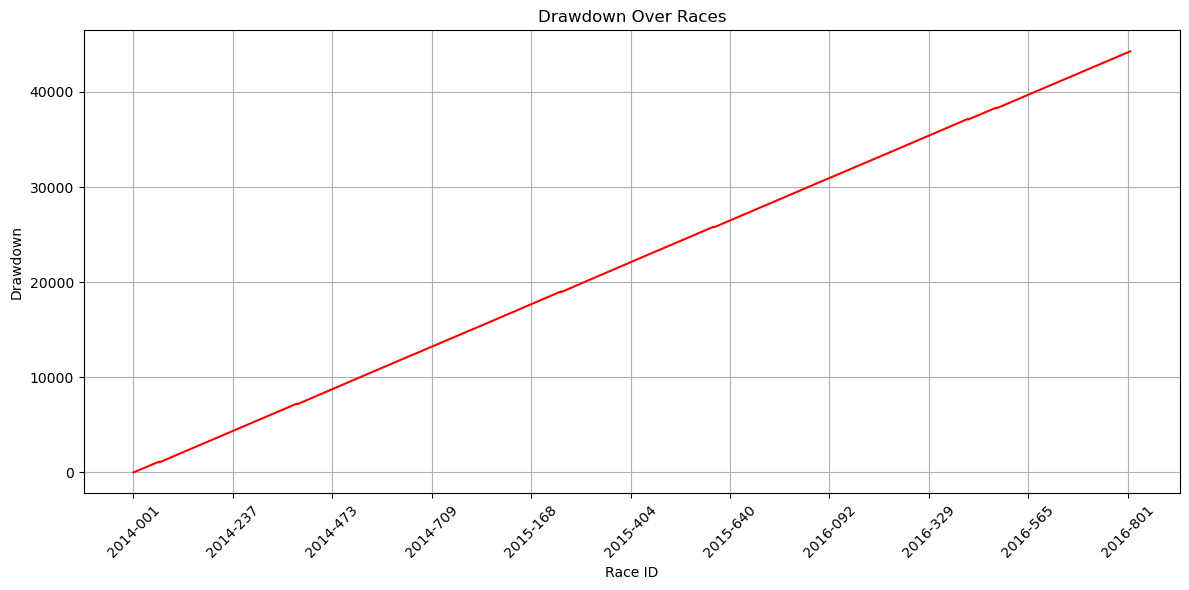

In [60]:
# Calculate the cumulative maximum wealth up to each point
subset_df['Cumulative_Max_Wealth'] = subset_df['Wealth'].cummax()

# Calculate drawdown as the difference between the current wealth and the cumulative max wealth
subset_df['Drawdown'] = subset_df['Cumulative_Max_Wealth'] - subset_df['Wealth']


plt.figure(figsize=(12, 6))
plt.plot(subset_df['race_id'], subset_df['Drawdown'], linestyle='-', color='red')

plt.title('Drawdown Over Races')
plt.xlabel('Race ID')
plt.ylabel('Drawdown')

# Adjust the x-axis labels similarly to your wealth curve plot for consistency
n = len(subset_df['race_id']) // 10
plt.xticks(subset_df['race_id'][::n], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion: Betting on every horse is a terrible strategy as the total implied probability (Sum of all the winning chances based on win-odds) is always greater than 100%. This means that the losses incurred from betting on all other horses besides the winner is disproportionately larger than the gains from winning. Minor Exception being the rare event in which 2 horses win, but this is happens only 0.25% of the time.